

Задача № 3 (для 2 курса)
 
Название: Автоматизация обработки машиночитаемых документов.
 
Описание: Вам будет выдан набор данных документов из системы документооборота небольшой вымышленной компании. На основе этого набора данных вам нужно построить граф знаний о компании, который включает:

● 	Организационную структуру (список подразделений). Есть

● 	Список сотрудников 

●  и их должностей. 

● 	Должностные обязанности и полномочия сотрудников.

На основе построенного графа знаний нужно разработать систему, которая ищет ошибки в проверочных документах (10 правильных документов, 10 документов с ошибками), например:

● 	Опечатки в названиях подразделений или ФИО сотрудников.

● 	Несуществующие подразделения или сотрудники, ошибки в должностях.

● 	Несоответствие тематики документа подразделению, в которое он направлен для исполнения (в бухгалтерию направлен документ с задачей по ИТ).
 
Ссылка на набор данных – https://www.dropbox.com/sh/d5h5f3yrql8x392/AACQ2WYa5qYCqjC8QuVZ5TJ4a?dl=1 

Вам будет передана открытая часть датасета с разметкой, закрытая часть датасета без разметки и проверочные документы (20 документов для подзадачи обнаружения ошибок в документах).
 
Требования к решению:
1.   Код программы построения графа знаний о компании (ссылка на GitHub), с помощью которого можно ответить на вопросы:
a.   Количество отделов.
b.   Количество сотрудников.
c.	К какому отделу относится конкретная задача.
2.   Код программы поиска документов с ошибками на основе графа знаний (ссылка на GitHub).
3.   Документы, в которых найдены ошибки.
 
Критерии оценки:
● 	За каждый найденный документ с ошибкой начисляется 10 баллов.
● 	За каждый документ, представленный как ошибочный, но в котором ошибки на самом деле нет, назначается штраф -1 балл.
 
Советы по реализации:
1.   Извлечь именованные сущности (NER) из текста можно с помощью библиотеки spacy (https://spacy.io/), pullenti, natasha или соответствующих моделей с huggingface (https://huggingface.co/).
2.   Для сущностей, для которых не удастся найти типовые предобученные модели (например, сущность «Задача» или «Департамент») организовать обучение модели с использованием открытой части датасета.
3.   Для построения графа связей в организации рекомендуется использовать библиотеку NetworkX - https://networkx.org/



### Устанавливаем библиотеки 


# Решение.

1. task_text: разбить на предложения. Выявить функционал. FIO_POSITION: ФИО, должность, функционал, отдел (не необходимо).
2. task_responsibles_people: - вывявить ФИО, должность, task_responsibles_groups: добавить отдел.
3. Собрать мешок слов: ФИО, должность, функционал, отдел.
4. Векторизировать мешок слов.
5. Из отделов построить 8 классов.
6. Обучить реккурентную нейросеть LSTM или GRU.
7. Протестировать на тестовом наборе данных.
8. Построить граф знаний.
9. Написать функцию соответствия предсказания с графом знаний.
10. Сделать презентацию проекта.


In [ ]:
#!pip install networkx
#!pip install --upgrade networkx
#!pip install pygraphviz pydot lxml
#!pip install pygraphviz
#!pytest networkx
#!pytest --pyargs networkx
#! pip install pymorphy2
#! pip install -U pip setuptools wheel
#! pip install -U spacy 
#! python -m spacy download en_core_web_sm
#! python -m spacy download ru_core_news_sm
#! pip install --user -U nltk
#! pip install -U liblinear-official
#! pip install natasha
#! pip install ipymarkup
#! pip install transformers sentencepiece sacremoses
#!pip install pymorphy2[fast]
#!pip install natasha spacy==3.3

#!python -m spacy download ru_core_news_sm
#!pip install tensorflow-text spacy==3.3
#!python -m spacy download ru_core_news_sm
#!pip install pymorphy2[fast] 
#!pip install python-docx



In [97]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from yargy.tokenizer import MorphTokenizer
from yargy import rule, or_, Parser
from yargy.predicates import eq, type as _t, normalized, gram
from ipymarkup import show_span_box_markup, show_span_line_markup
from yargy.pipelines import morph_pipeline as mp, caseless_pipeline as cp
from yargy.interpretation import fact
from IPython.display import display

# Морфологический анализ
import pymorphy2

# Синтаксический анализ
import spacy
from spacy import displacy
from spacy.symbols import nsubj, VERB

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

import io
import re
import string
import tqdm

import requests

import tensorflow as tf
import tensorflow_text as tf_text
from tensorflow.keras import layers
import gensim.models

from transformers import pipeline, AutoTokenizer, AutoConfig, AutoModelForTokenClassification

from docx import Document

In [3]:
directory = 'hackaton_2023_01/task_3/full_dataset/json/'
data = []
for n in range(9999):
    name = str(n) + '.json'
    try:
        with open(directory + name, "r") as readFile:
            jsonData = json.load(readFile)
            jsonData["id"] = n
            data.append(jsonData)
    except ValueError:
        continue

In [4]:
with open('merged_data.json', "r") as readFile:
            merge_data = json.load(readFile)

### Определяем количество департаментов в компании

In [5]:
DEPARTMENTS = []
for n in range(10000):
    try:
        for i in range(1,30):
            DEPARTMENTS.append(data[n]['Tasks']['Task{}'.format(i)]['task_responsibles_groups'])
    except KeyError:
        continue
    except IndexError:
        continue


In [6]:
FIO_POSITION = []
for n in range(10000):
    try:
        for i in range(1,20):
            FIO_POSITION.append(data[n]['Tasks']['Task{}'.format(i)]['task_responsibles_people'])
    except KeyError:
        continue
    except IndexError:
        continue

In [7]:
TASK = []
for n in range(10000):
    try:
        for i in range(1,30):
            TASK.append(data[n]['Tasks']['Task{}'.format(i)]['task_text'])
    except KeyError:
        continue
    except IndexError:
        continue

In [8]:
POSITION = []
for n in range(10000):
    try:
        for i in range(1,30):
            POSITION.append(data[n]['Tasks']['Global_supervisor'][i])
    except KeyError:
        continue
    except IndexError:
        continue

### Очищаем данные

In [9]:
def text_split(text: str):
    pouch_of_words = []
    for line in text:
        line = line.split()
        pouch_of_words.append(line)
    return pouch_of_words
     

In [11]:
#text_split(FIO_POSITION[:2])

In [13]:
def token_words_split(text: str):
    pouch_of_words = []
    if type(text) == list:
        for line in text:
            TOKENIZER = word_tokenize(line)
            pouch_of_words.append(TOKENIZER)
        return pouch_of_words

#pouch_of_words = token_words_split(FIO_POSITION[:2])
#pouch_of_words

In [17]:
def split_spacy(text: str):
    pouch_of_words = []
    nlp = spacy.load('ru_core_news_sm')
    if type(text) == list:
        for line in text:
            doc = nlp(line)
            for token in doc:
                pouch_of_words.append(token)
    return pouch_of_words

In [ ]:
#split_spacy(FIO_POSITION[:2])

In [19]:
nltk.download('punkt')
def sentence(text: str):
    sentences = sent_tokenize(text)
    return sentences

[nltk_data] Downloading package punkt to /Users/macbook/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Морфологический анализ

In [20]:
morph = pymorphy2.MorphAnalyzer()

In [22]:
def morph_word(words: str):
    words = split_spacy(words)
    morph_words = []
    for word in words:
        print(word)

#morph_word(POSITION[:1])

### Синтаксический анализ

### Разделяем текст на предложения.

In [25]:
nltk.download('punkt')
def sentence(text: str):
    pouch_of_sentence = []
    if type(text) == list:
        for line in text:
            sentences = sent_tokenize(line)
            pouch_of_sentence.append(sentences)
    return str(pouch_of_sentence)
    
text = sentence(FIO_POSITION[10:12])
text

[nltk_data] Downloading package punkt to /Users/macbook/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


"[['Контроль над выполнением настоящего распоряжения оставляю за собой'], ['Обеспечение выполнения возложить на специалиста третей категории бухгалтерии Александрова А.С.']]"

In [26]:
### Использование библиотеки natasha в данные момент дорабатываются.

In [31]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    
    NewsNERTagger,
    
    PER,
    LOC,
    NamesExtractor,
    DatesExtractor,
    MoneyExtractor,
    AddrExtractor,
 
    Doc
)


In [28]:
#segmenter = Segmenter()
#morph_vocab = MorphVocab()

#emb = NewsEmbedding()
#morph_tagger = NewsMorphTagger(emb)
#syntax_parser = NewsSyntaxParser(emb)
#ner_tagger = NewsNERTagger(emb)

#names_extractor = NamesExtractor(morph_vocab)
#dates_extractor = DatesExtractor(morph_vocab)
#money_extractor = MoneyExtractor(morph_vocab)
#addr_extractor = AddrExtractor(morph_vocab)

In [29]:
#syntax_parser = NewsSyntaxParser(emb)


In [30]:
#doc_n = Doc(text)

In [ ]:
#for tocken in doc_n.tokens:
#    print(tocken)

In [ ]:
#doc_n.parse_syntax(syntax_parser)

In [ ]:
#for tocken in doc_n.tokens:
#    print(tocken)

In [ ]:
#doc_n.sents[0].syntax.print()

### Выявление ФИО, должности, специализации.


In [32]:
#FIO = []

#for tocken in doc_n.tokens:
#    if tocken.rel == 'flat:name' or tocken.rel == 'appos':
#        if tocken.rel == 'appos':
#            surn = tocken.text 
#            if surn in FIO:
#                pass
#            else:
#                FIO.append(surn)
#        elif tocken.rel == 'flat:name':
#            IO = tocken.text + '.'      
#            FIO.append(IO)
           


In [ ]:
#doc_n.segment(segmenter) 

In [ ]:
#doc_n.tag_morph(morph_tagger)

In [ ]:
#doc_n.tag_ner(ner_tagger)

In [ ]:
#doc_n.parse_syntax(syntax_parser)

In [ ]:
#display(doc_n.tokens[:5])

In [ ]:
#display(doc_n.sents)

In [ ]:
#display(doc_n.tokens)

In [33]:
#for span in doc_n.spans:
#    span.normalize(morph_vocab)
   
#
#keywords = {_.text: _.normal for _ in doc_n.spans if _.text != _.normal}
#print(span)

In [34]:
#for token in doc_n.tokens:
#    token.lemmatize(morph_vocab)
    
#{_.text: _.lemma for _ in doc_n.tokens}

### Создание дистрибутивно-семантической модели.

In [ ]:
#!pip install navec

In [ ]:
#!curl https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar -O navec_hudlit_v1_12B_500K_300d_100q.tar

In [ ]:
#from navec import Navec

In [ ]:
#navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

In [ ]:
#navec['абакумов']

In [ ]:
#!pip install pymorphy2[fast] 

### Построение датафрейма

#### Определение числа департаментов и их классиикация.

In [35]:
DEPARTMENTS = set(DEPARTMENTS)
DEPARTMENTS_list = list(DEPARTMENTS)

In [37]:
value = []
for i in range(1,9):
    value.append(i)

In [38]:
def classes(list: list) -> dict:
    result = {}

    for n in range(8):
        dep = list[n]
        result[dep] = value[n]

    return result

In [40]:
classes_dep = classes(DEPARTMENTS_list)

### Начало работы с моделью.

In [41]:
df = pd.json_normalize(merge_data)

     

df.set_index('id', inplace=True)
df.sort_index(inplace=True) # сортировка по индексу=id 
     

df.columns = df.columns.str.replace("Tasks.", "")

/var/folders/5g/7vyd0lbj2w52qz6789tj57hc0000gn/T/ipykernel_5482/2129567716.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("Tasks.", "")


In [46]:
df.head()

,Task1.task_text,Task1.task_responsibles_people,Task1.task_responsibles_groups,Task1.task_deadline,Global_supervisor,Global_deadline,Task2.task_text,Task2.task_responsibles_people,Task2.task_responsibles_groups,Task2.task_deadline,...,Task7.task_responsibles_groups,Task7.task_deadline,Task8.task_text,Task8.task_responsibles_people,Task8.task_responsibles_groups,Task8.task_deadline,Task9.task_text,Task9.task_responsibles_people,Task9.task_responsibles_groups,Task9.task_deadline
id,,,,,,,,,,,,,,,,,,,,,
0,Закупить книги. Срок завершения: 19 апр 15.,Ответственность за исполнение распоряжения воз...,Административно-хозяйственный отдел,"[19 апр 15, 1429383600.0]",[Ответственность за исполнение распоряжения во...,"[11 апреля 2013 года, 1365616800.0]",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Провести анализ поставщиков для замены вышедше...,Ответственность за исполнение распоряжения воз...,Служба ИТ,"[24 октября 12, 1351015200.0]",[Ответственность за исполнение распоряжения во...,"[03 июня 2013 года, 1370196000.0]",Выполнить ремонт кабеля сети передачи данных м...,Контроль над выполнением приказа возложить на ...,Служба ИТ,"[12 авг 13, 1376244000.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Провести рефакторинг программного обеспечения ...,Контроль над исполнением распоряжения оставить...,Отдел разработки систем,"[24.12.20, 1608750000.0]",[Контроль над исполнением распоряжения оставит...,"[08 окт 2014 г., 1412704800.0]",Провести рефакторинг программного обеспечения ...,Ответственным за исполнение настоящего приказа...,Отдел разработки систем,"[01 января 2018 года, 1514746800.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Оплатить командировочные расходы.\nОпределить ...,Контроль над выполнением настоящего распоряжен...,Бухгалтерия,"[26 июля 2019 г., 1564081200.0]",[Контроль над выполнением настоящего распоряже...,"[10.12.18, 1544382000.0]",Провести аудит персональных данных в информаци...,Обеспечение выполнения возложить на специалист...,Бухгалтерия,"[17.09.13, 1379354400.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Согласовать смету на выполнение работ компание...,Контроль над выполнением настоящего распоряжен...,Бухгалтерия,"[12 янв 2019 г., 1547233200.0]",[Контроль над выполнением настоящего распоряже...,"[19.03.2016, 1458327600.0]",Выделить средства на проведение обучения.\nУст...,Ответственным за исполнение настоящего приказа...,Бухгалтерия,"[26.09.2016, 1474830000.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
#df = pd.read_csv('df_all.csv')

In [48]:
df = df.replace(classes_dep)

In [49]:
df_not_dead_line = df.drop(['Global_deadline','Task1.task_deadline','Task2.task_deadline','Task3.task_deadline','Task4.task_deadline',
              'Task5.task_deadline','Task6.task_deadline','Task7.task_deadline',
             'Task8.task_deadline','Task9.task_deadline'], axis = 1)


In [51]:
df = df.fillna(0)

In [ ]:
### Разделение задания на предложения

In [55]:
for n in range(len(df)):
    try:
        df['Task{}.task_text'.format(n)][n] = df['Task{}.task_text'.format(n)][n].split('.')[0]
    except TypeError:
        continue
    except AttributeError:
        continue
    except IndexError:
        continue
    except KeyError:
        continue


/var/folders/5g/7vyd0lbj2w52qz6789tj57hc0000gn/T/ipykernel_5482/2788789353.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Task{}.task_text'.format(n)][n] = df['Task{}.task_text'.format(n)][n].split('.')[0]


,Task1.task_text,Task1.task_responsibles_people,Task1.task_responsibles_groups,Task1.task_deadline,Global_supervisor,Global_deadline,Task2.task_text,Task2.task_responsibles_people,Task2.task_responsibles_groups,Task2.task_deadline,...,Task7.task_responsibles_groups,Task7.task_deadline,Task8.task_text,Task8.task_responsibles_people,Task8.task_responsibles_groups,Task8.task_deadline,Task9.task_text,Task9.task_responsibles_people,Task9.task_responsibles_groups,Task9.task_deadline
id,,,,,,,,,,,,,,,,,,,,,
0,Закупить книги. Срок завершения: 19 апр 15.,Ответственность за исполнение распоряжения воз...,5,"[19 апр 15, 1429383600.0]",[Ответственность за исполнение распоряжения во...,"[11 апреля 2013 года, 1365616800.0]",0,0,0.0,0,...,0.0,0,0,0,0.0,0,0,0,0.0,0
1,Провести анализ поставщиков для замены вышедше...,Ответственность за исполнение распоряжения воз...,7,"[24 октября 12, 1351015200.0]",[Ответственность за исполнение распоряжения во...,"[03 июня 2013 года, 1370196000.0]",Выполнить ремонт кабеля сети передачи данных м...,Контроль над выполнением приказа возложить на ...,7.0,"[12 авг 13, 1376244000.0]",...,0.0,0,0,0,0.0,0,0,0,0.0,0
2,Провести рефакторинг программного обеспечения ...,Контроль над исполнением распоряжения оставить...,8,"[24.12.20, 1608750000.0]",[Контроль над исполнением распоряжения оставит...,"[08 окт 2014 г., 1412704800.0]",Провести рефакторинг программного обеспечения ...,Ответственным за исполнение настоящего приказа...,8.0,"[01 января 2018 года, 1514746800.0]",...,0.0,0,0,0,0.0,0,0,0,0.0,0
3,Оплатить командировочные расходы.\nОпределить ...,Контроль над выполнением настоящего распоряжен...,3,"[26 июля 2019 г., 1564081200.0]",[Контроль над выполнением настоящего распоряже...,"[10.12.18, 1544382000.0]",Провести аудит персональных данных в информаци...,Обеспечение выполнения возложить на специалист...,3.0,"[17.09.13, 1379354400.0]",...,0.0,0,0,0,0.0,0,0,0,0.0,0
4,Согласовать смету на выполнение работ компание...,Контроль над выполнением настоящего распоряжен...,3,"[12 янв 2019 г., 1547233200.0]",[Контроль над выполнением настоящего распоряже...,"[19.03.2016, 1458327600.0]",Выделить средства на проведение обучения.\nУст...,Ответственным за исполнение настоящего приказа...,3.0,"[26.09.2016, 1474830000.0]",...,0.0,0,0,0,0.0,0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,Выполнить ремонт кабеля сети передачи данных м...,Ответственным за исполнение настоящего приказа...,7,"[21 июня 20, 1592679600.0]",[Ответственным за исполнение настоящего приказ...,"[11 января 2015 года, 1420916400.0]",Выполнить перезагрузку серверного оборудования...,За контроль над исполнением распоряжения назна...,7.0,"[20.11.2021, 1637348400.0]",...,0.0,0,0,0,0.0,0,0,0,0.0,0
9995,Подготовить отчеты для налоговой службы.\nПрис...,Ответственным за исполнение настоящего приказа...,3,"[14 сен 2017 г., 1505329200.0]",[Ответственным за исполнение настоящего приказ...,"[22 августа 2016 года, 1471806000.0]",Перечислить необходимые средства для проведени...,За контроль над исполнением распоряжения назна...,3.0,"[20 июля 2013 г., 1374256800.0]",...,0.0,0,0,0,0.0,0,0,0,0.0,0
9996,Закупить необходимое количество лицензий офисн...,Контроль над исполнением распоряжения оставить...,7,"[03 октября 2020 года, 1601665200.0]",[Контроль над исполнением распоряжения оставит...,"[26 июля 12, 1343239200.0]",Закупить необходимое количество клавиатур и ма...,Ответственным за контролем над исполнением выш...,7.0,"[16 августа 2012 года, 1345053600.0]",...,7.0,"[02.12.14, 1417460400.0]",Подключить и настроить видеокамеру для работы ...,За контроль над исполнением распоряжения назна...,7.0,"[07 апр 15, 1428346800.0]",Провести централизованную смену паролей для до...,Контроль над выполнением настоящего распоряжен...,7.0,"[08.10.2019, 1570474800.0]"


In [ ]:
#df_no_deadline.to_csv('df_no_deadline.csv')

## Построение модели классификации (только по отделам).

In [57]:
#!install tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.model_selection import train_test_split

In [60]:
X = df.drop(['Task1.task_responsibles_groups','Task2.task_responsibles_groups','Task3.task_responsibles_groups',
             'Task4.task_responsibles_groups',
            'Task5.task_responsibles_groups','Task6.task_responsibles_groups','Task7.task_responsibles_groups',
            'Task8.task_responsibles_groups','Task9.task_responsibles_groups'], axis = 1)
X.head()

,Task1.task_text,Task1.task_responsibles_people,Task1.task_deadline,Global_supervisor,Global_deadline,Task2.task_text,Task2.task_responsibles_people,Task2.task_deadline,Task3.task_text,Task3.task_responsibles_people,...,Task6.task_deadline,Task7.task_text,Task7.task_responsibles_people,Task7.task_deadline,Task8.task_text,Task8.task_responsibles_people,Task8.task_deadline,Task9.task_text,Task9.task_responsibles_people,Task9.task_deadline
id,,,,,,,,,,,,,,,,,,,,,
0,Закупить книги. Срок завершения: 19 апр 15.,Ответственность за исполнение распоряжения воз...,"[19 апр 15, 1429383600.0]",[Ответственность за исполнение распоряжения во...,"[11 апреля 2013 года, 1365616800.0]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Провести анализ поставщиков для замены вышедше...,Ответственность за исполнение распоряжения воз...,"[24 октября 12, 1351015200.0]",[Ответственность за исполнение распоряжения во...,"[03 июня 2013 года, 1370196000.0]",Выполнить ремонт кабеля сети передачи данных м...,Контроль над выполнением приказа возложить на ...,"[12 авг 13, 1376244000.0]",Создать и настроить виртуальную машину в соотв...,Контроль над исполнением распоряжения оставить...,...,0,0,0,0,0,0,0,0,0,0
2,Провести рефакторинг программного обеспечения ...,Контроль над исполнением распоряжения оставить...,"[24.12.20, 1608750000.0]",[Контроль над исполнением распоряжения оставит...,"[08 окт 2014 г., 1412704800.0]",Провести рефакторинг программного обеспечения ...,Ответственным за исполнение настоящего приказа...,"[01 января 2018 года, 1514746800.0]",Провести анализ накопленного технического долг...,За контроль над исполнением распоряжения назна...,...,"[18.11.17, 1510945200.0]",0,0,0,0,0,0,0,0,0
3,Оплатить командировочные расходы.\nОпределить ...,Контроль над выполнением настоящего распоряжен...,"[26 июля 2019 г., 1564081200.0]",[Контроль над выполнением настоящего распоряже...,"[10.12.18, 1544382000.0]",Провести аудит персональных данных в информаци...,Обеспечение выполнения возложить на специалист...,"[17.09.13, 1379354400.0]",Перечислить необходимые средства на закупку об...,Контроль над выполнением настоящего распоряжен...,...,0,0,0,0,0,0,0,0,0,0
4,Согласовать смету на выполнение работ компание...,Контроль над выполнением настоящего распоряжен...,"[12 янв 2019 г., 1547233200.0]",[Контроль над выполнением настоящего распоряже...,"[19.03.2016, 1458327600.0]",Выделить средства на проведение обучения.\nУст...,Ответственным за исполнение настоящего приказа...,"[26.09.2016, 1474830000.0]",0,0,...,0,0,0,0,0,0,0,0,0,0


### Определение целевой переменной.

In [63]:
y = df['Task1.task_responsibles_groups']
y.head()

id
0    5
1    7
2    8
3    3
4    3
Name: Task1.task_responsibles_groups, dtype: int64

In [64]:
X.shape, y.shape

((9999, 29), (9999,))

## Определение словарей для токенизации и векторизация слов.

In [66]:
task_1 = X['Task1.task_text']
task_2 = X['Task2.task_text']
task_3 = X['Task3.task_text']
task_4 = X['Task4.task_text']
task_5 = X['Task5.task_text']
task_6 = X['Task6.task_text']
task_7 = X['Task7.task_text']
task_8 = X['Task8.task_text']
task_9 = X['Task9.task_text']

Task1_task_responsibles_people = X['Task1.task_responsibles_people']
Task2_task_responsibles_people = X['Task2.task_responsibles_people']
Task3_task_responsibles_people = X['Task3.task_responsibles_people']
Task4_task_responsibles_people = X['Task4.task_responsibles_people']
Task5_task_responsibles_people = X['Task5.task_responsibles_people']
Task6_task_responsibles_people = X['Task6.task_responsibles_people']
Task7_task_responsibles_people = X['Task7.task_responsibles_people']
Task8_task_responsibles_people = X['Task8.task_responsibles_people']
Task9_task_responsibles_people = X['Task9.task_responsibles_people']

Global_supervisor = X['Global_supervisor']

### Токенизация и векторизация слов и предложений.

In [70]:
tokenizer = Tokenizer(num_words=num_words)

In [71]:
tokenizer.fit_on_texts(Task1_task_responsibles_people)

In [72]:
sequences = tokenizer.texts_to_sequences(Task1_task_responsibles_people)

In [73]:
X = pad_sequences(sequences, maxlen=max_review_len)

### Разбиение датасета на тренировчную и тестовую выборки.

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    
                                                    test_size=0.1,
                                                    random_state=50)
X_train.shape, y_train.shape

((8999, 100), (8999,))

In [78]:
### Приведение данные к другому типу и категоризация классов.

In [79]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
y_train = utils.to_categorical(y_train - 1, nb_classes)
y_test = utils.to_categorical(y_test - 1, nb_classes)
X_train.shape, y_train.shape


((8999, 100), (8999, 8))

## Создаём нейросеть

### Загрузка библиотек

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from keras.utils import to_categorical

### Определение гиперпараметров модели.

In [82]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина задания
max_news_len = 100
# Количество классов отделов
nb_classes = 8

### Простая свёрточная сеть


In [83]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(8, activation='softmax'))

model_cnn.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history_cnn = model_cnn.fit(X_train, 
                            y_train, 
                            epochs=5,
                            batch_size=128,
                            validation_split=0.1,
                            )

Epoch 1/5


2023-01-22 20:01:47.525677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


64/64 [==============================] - 4s 44ms/step - loss: 1.3482 - accuracy: 0.5872 - val_loss: 0.5191 - val_accuracy: 0.8533
Epoch 2/5
64/64 [==============================] - 3s 39ms/step - loss: 0.3087 - accuracy: 0.8957 - val_loss: 0.1760 - val_accuracy: 0.9311
Epoch 3/5
64/64 [==============================] - 3s 40ms/step - loss: 0.2064 - accuracy: 0.9169 - val_loss: 0.1715 - val_accuracy: 0.9311
Epoch 4/5
64/64 [==============================] - 3s 41ms/step - loss: 0.2017 - accuracy: 0.9169 - val_loss: 0.1654 - val_accuracy: 0.9311
Epoch 5/5
64/64 [==============================] - 3s 39ms/step - loss: 0.2005 - accuracy: 0.9162 - val_loss: 0.1635 - val_accuracy: 0.9211


In [84]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           320000    
                                                                 
 conv1d (Conv1D)             (None, 96, 250)           40250     
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               32128     
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 393,410
Trainable params: 393,410
Non-trainable params: 0
__________________________________________________

### Смотрим графики по визуализации предсказаний для определения переобучения модели.

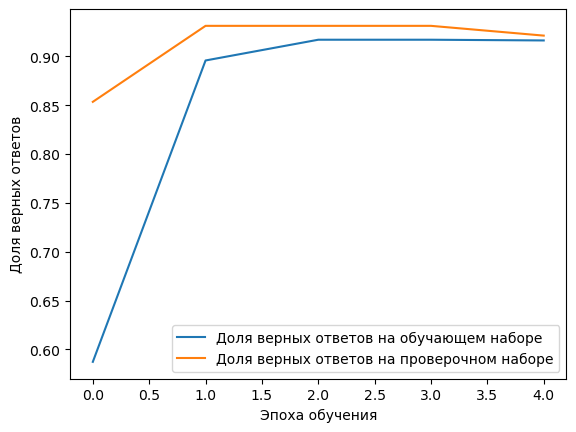

In [85]:
plt.plot(history_cnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Сеть LSTM

In [86]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(8, activation='softmax'))

In [87]:
model_lstm.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [88]:
history_lstm = model_lstm.fit(X_train, 
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              )

Epoch 1/5
64/64 [==============================] - 5s 42ms/step - loss: 1.8643 - accuracy: 0.5548 - val_loss: 1.5285 - val_accuracy: 0.7256
Epoch 2/5
64/64 [==============================] - 2s 36ms/step - loss: 1.1485 - accuracy: 0.7189 - val_loss: 0.7759 - val_accuracy: 0.7700
Epoch 3/5
64/64 [==============================] - 2s 35ms/step - loss: 0.6511 - accuracy: 0.8413 - val_loss: 0.4983 - val_accuracy: 0.9033
Epoch 4/5
64/64 [==============================] - 2s 35ms/step - loss: 0.4540 - accuracy: 0.9070 - val_loss: 0.3721 - val_accuracy: 0.9211
Epoch 5/5
64/64 [==============================] - 2s 33ms/step - loss: 0.3426 - accuracy: 0.9136 - val_loss: 0.2717 - val_accuracy: 0.9311


In [89]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           320000    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
Total params: 323,272
Trainable params: 323,272
Non-trainable params: 0
_________________________________________________________________


### Смотрим графики по визуализации предсказаний для определения переобучения модели.

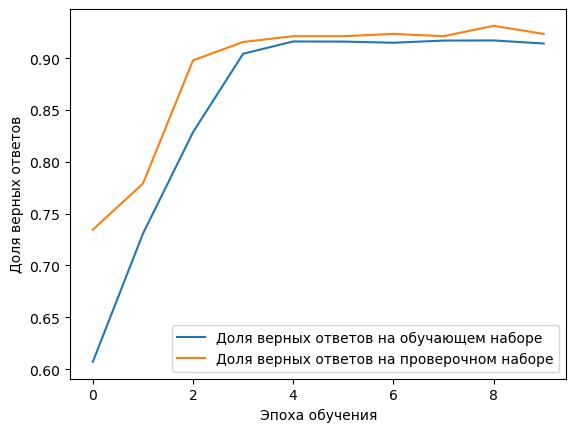

In [166]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

### Сеть GRU

In [90]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_news_len))
model_gru.add(GRU(32))
model_gru.add(Dense(8, activation='softmax'))

In [91]:
model_gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [92]:
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 32)           320000    
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense_3 (Dense)             (None, 8)                 264       
                                                                 
Total params: 326,600
Trainable params: 326,600
Non-trainable params: 0
_________________________________________________________________


In [93]:
history_gru = model_gru.fit(X_train, 
                              y_train, 
                              epochs=10,
                              batch_size=128,
                              validation_split=0.1,
                              )

Epoch 1/10
64/64 [==============================] - 6s 48ms/step - loss: 1.7581 - accuracy: 0.5304 - val_loss: 1.1950 - val_accuracy: 0.7178
Epoch 2/10
64/64 [==============================] - 2s 39ms/step - loss: 0.7302 - accuracy: 0.7926 - val_loss: 0.4421 - val_accuracy: 0.8711
Epoch 3/10
64/64 [==============================] - 3s 40ms/step - loss: 0.3842 - accuracy: 0.8841 - val_loss: 0.2786 - val_accuracy: 0.9156
Epoch 4/10
64/64 [==============================] - 3s 44ms/step - loss: 0.2675 - accuracy: 0.9120 - val_loss: 0.2019 - val_accuracy: 0.9378
Epoch 5/10
64/64 [==============================] - 3s 40ms/step - loss: 0.2235 - accuracy: 0.9168 - val_loss: 0.1801 - val_accuracy: 0.9378
Epoch 6/10
64/64 [==============================] - 3s 40ms/step - loss: 0.2151 - accuracy: 0.9153 - val_loss: 0.1740 - val_accuracy: 0.9233
Epoch 7/10
64/64 [==============================] - 2s 39ms/step - loss: 0.2082 - accuracy: 0.9149 - val_loss: 0.1721 - val_accuracy: 0.9211
Epoch 8/10
64

### Смотрим графики по визуализации предсказаний для определения переобучения модели.

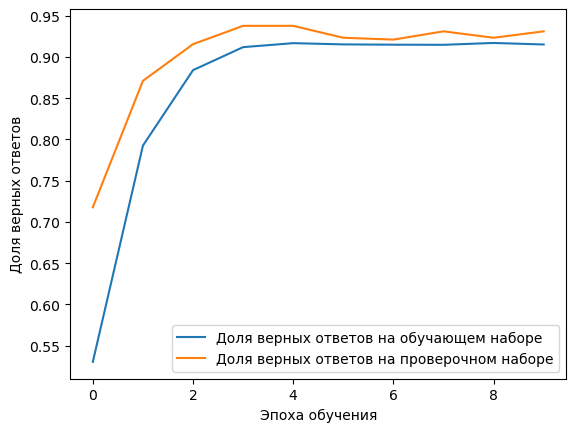

In [94]:
plt.plot(history_gru.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

### Метрики тестовой выборки для свёрточной нейросети сети.

In [172]:
model_cnn.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 0s 4ms/step - loss: 0.1880 - accuracy: 0.9240


[0.18800990283489227, 0.9240000247955322]

### Метрики тестовой выборки для сети LSTM.

In [95]:
model_lstm.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 1s 7ms/step - loss: 0.2867 - accuracy: 0.9270


[0.28674453496932983, 0.9269999861717224]

### Метрики тестовой выборки для сети GRU.

In [96]:
model_gru.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 1s 7ms/step - loss: 0.1851 - accuracy: 0.9270


[0.18506701290607452, 0.9269999861717224]

### Проверка документа из датасетов output_decrees.

In [129]:
directory = 'hackaton_2023_01/task_3/output_decrees/docx/'
series = []
filesText = []

print("Введите название файла: ")

name = str(input())

def file(name):
    

    fileText = ''

    document = Document(directory + name)
    for paragraph in document.paragraphs:
        fileText += paragraph.text + '\n'
    
    filesText.append(fileText)
    print(fileText)
    return fileText

fileText = file(name)

Введите название файла: 


 160.docx



Отдел тестирования Департамента разработки


О закупке

i.. Внести в Регламент, утвержденный приказом Генерального директора от 11.05.2016 N 276, изменение, исключив из пункта 1.11 слова "а также деятельность Руководителя удаленного офиса".
Ответственность за исполнение задачи возложить на Контент менеджера Роговцова Беньямина.
Установить срок выполнения задачи до 19.08.22.

ii. пункт 5.1.2 дополнить абзацем четвертым следующего содержания:
"При официальной переписке с межгосударственными (международными) органами, компетентными органами и должностными лицами иностранных государств, иностранными гражданами и организациями используется отдельный бланк с продольным расположением реквизитов на двух языках - русском и английском (приложение N 61)." Определить срок исполнения задачи вплоть до 0.
Контроль над выполнением вышеуказанного поручения возложить на Контент менеджера Олабухина Этьена.

iii. пункт 2.4.1.3 изложить в следующей редакции:
"2.4.1.3. Входящие документы на иностранных язы

# Векторизация текста

In [130]:
sequence = tokenizer.texts_to_sequences([fileText])

In [131]:
data = pad_sequences(sequence, maxlen=max_review_len)

### Предсказание модели cnn

In [132]:
result = model_cnn.predict(data)

1/1 [==============================] - 0s 27ms/step


### Вывод результата

In [133]:
np.round(result, 2)

array([[0.57, 0.08, 0.14, 0.04, 0.06, 0.03, 0.04, 0.05]], dtype=float32)

In [134]:
classes_dep

{'Отдел тестирования': 1,
 'Отдел архитектуры': 2,
 'Бухгалтерия': 3,
 'Отдел эксплуатации': 4,
 'Административно-хозяйственный отдел': 5,
 'Отдел проектирования': 6,
 'Служба ИТ': 7,
 'Отдел разработки систем': 8}

### Модель LSTM

In [135]:
result = model_lstm.predict(data)


1/1 [==============================] - 0s 32ms/step


In [136]:
np.round(result, 2)

array([[0.01, 0.13, 0.34, 0.03, 0.02, 0.04, 0.32, 0.1 ]], dtype=float32)

In [125]:
classes_dep

{'Отдел тестирования': 1,
 'Отдел архитектуры': 2,
 'Бухгалтерия': 3,
 'Отдел эксплуатации': 4,
 'Административно-хозяйственный отдел': 5,
 'Отдел проектирования': 6,
 'Служба ИТ': 7,
 'Отдел разработки систем': 8}

### Предсказание модели GRU

In [137]:
result = model_gru.predict(data)


1/1 [==============================] - 0s 29ms/step


In [138]:
np.round(result, 2)

array([[0.01, 0.03, 0.04, 0.  , 0.05, 0.03, 0.57, 0.26]], dtype=float32)

In [112]:
classes_dep

{'Отдел тестирования': 1,
 'Отдел архитектуры': 2,
 'Бухгалтерия': 3,
 'Отдел эксплуатации': 4,
 'Административно-хозяйственный отдел': 5,
 'Отдел проектирования': 6,
 'Служба ИТ': 7,
 'Отдел разработки систем': 8}

# Выводы:

На документах, не учавствовавших в в обучении модели предсказывают классы по большему 
синтаксическому совпадению слов в загруженном документе, а также по частотности слов, 
относящихся к классам при обучении модели,
в этом документе. 

Для улучшения нейросети необходимо:
    
    1. Провести семантический анализ предложения. Использовать словарь синонимов к ключевым словам.
    
    2. Использовать порядок слов в предложении.
    
    3. Применить лямбда исчисления и разбить слова предложения на примитивы.
    
        - Слово.
        
        - Его определение.
        
        - Пример сочетания заданного слова с другими.
        
        - Составление фраз и предложений с этим словом.
        
    4. Определить связи между собой различными смысловыми отношениями: соединительными, 
пояснительными, противительными, временными и пр. 

    5. Определить основные виды связи:
    
        Параллельные связи:

        - Одинаковый порядок слов. 

        - Одинаковые грамматические формы слов.

        - Вводные слова и наречия места, времени. 	

        Цепнык связи:
        
        - Повтор ключевого слова. 

        - Замена его синонимом, синонимическим оборотом, местоимением или однокоренным словом. 
        Для этого сделать или хагрузить словарь синонимов.

        - Повтор того или иного члена предложения.

        - Семантические и ассоциативные связи (найти и создать правила в блиблотеки yargy).

    6. Провести смысловой анализ текста.
    7. Провести смысловой анализ предложения. (Некоторые пункты пересекаются.)

### Строим однонаправленный граф. (В процессе разработки.)

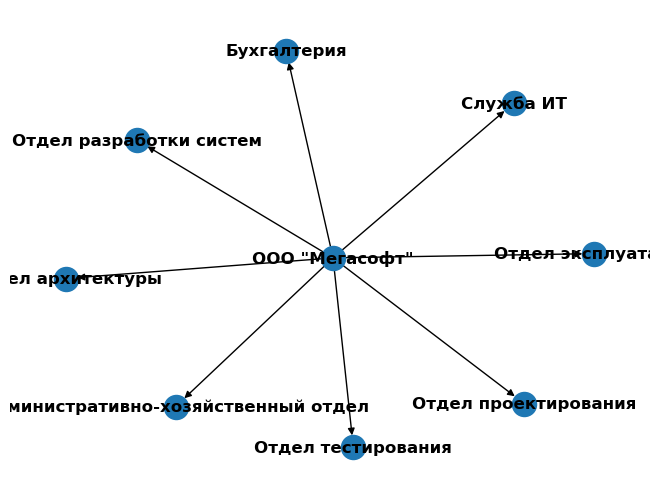

In [142]:
DG = nx.DiGraph()


DG.add_edge('ООО "Мегасофт"', DEPARTMENTS_list[0]) 
DG.add_edge('ООО "Мегасофт"', DEPARTMENTS_list[1]) 
DG.add_edge('ООО "Мегасофт"', DEPARTMENTS_list[2]) 
DG.add_edge('ООО "Мегасофт"', DEPARTMENTS_list[3]) 
DG.add_edge('ООО "Мегасофт"', DEPARTMENTS_list[4]) 
DG.add_edge('ООО "Мегасофт"', DEPARTMENTS_list[5]) 
DG.add_edge('ООО "Мегасофт"', DEPARTMENTS_list[6]) 
DG.add_edge('ООО "Мегасофт"', DEPARTMENTS_list[7]) 

nx.draw(DG, with_labels=True, font_weight='bold')